# Comparison of JosephsonCircuits.jl examples, using either JJ or NL components  

This notebook handles the Julia simulation of nonlinear circuits using Kevin O'Brien's JosephsonCircuits.jl package.  
It contains examples showing that the updated version of JosephsonCircuits.jl is running correctly.  

In [1]:
# Cell 1a: Initial Setup (Run ONCE per session)
# Julia configuration is controlled by julia_setup.py constants:
# - USE_LOCAL_FORK: Toggle local development vs remote
# - USE_GITHUB_FORK: Toggle GitHub fork vs registered (when USE_LOCAL_FORK=False)

from twpa_design import julia_setup

# Initialize julia_ready flag
julia_ready = False

# Setup Julia (configuration is in julia_setup.py)
print("🚀 Setting up Julia...")
jl = julia_setup.get_julia_for_session()

# Try to load JosephsonCircuits
try:
    jl.eval("using JosephsonCircuits")
    
    # Verify what version is loaded
    actual_path = jl.eval("pathof(JosephsonCircuits)")
    print(f"✅ SUCCESS! Using JosephsonCircuits from: {actual_path}")
    
    # Use helper function to check which version (no hardcoded UUIDs!)
    source_type = julia_setup.check_package_source(jl)
    
    if source_type == "local":
        print("🔥 Hot-reloading enabled - edit .jl files and changes auto-reload!")
    elif source_type == "github":
        print("📦 Using GitHub fork with Taylor expansion feature")
    elif source_type == "registered":
        print("📦 Using registered version")
    else:
        print("⚠️ Could not determine package source")
    
    julia_ready = True
        
except Exception as e:
    print(f"❌ Failed to load JosephsonCircuits: {e}")
    print("Check julia_setup.py configuration")
    julia_ready = False

🚀 Setting up Julia...
🚀 Initializing new Julia session...
📍 Using Julia from: C:\Users\mbm2\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32
Julia version: julia version 1.10.0
⬆️  Upgraded to Julia 1.11.5
📦 Using GitHub fork: https://github.com/MaxMalnou/JosephsonCircuits.jl
   Branch: taylor-expansion-feature
  🔍 Checking if GitHub fork is already installed...
  📦 GitHub fork not found, installing...
  🔧 Configuring SSL certificates for GitHub access...
  ✓ SSL configuration set
  📦 Cleaning up existing installations...
  ✓ Removed existing version
  ℹ️ No dev version to free
  🔧 Cloning from GitHub fork...
  ✅ Clone completed successfully
  📦 Loading JosephsonCircuits...
  🔍 Verifying installation...
  📍 Package loaded from: C:\Users\mbm2\.julia\packages\JosephsonCircuits\bUSDh\src\JosephsonCircuits.jl
  ✅ Successfully using GitHub fork!
✅ SUCCESS! Using JosephsonCircuits from: C:\Users\mbm2\.julia\packages\JosephsonCircuits\bUSDh\src\JosephsonCircuits.jl
📦 Using GitHub fork with Taylo

In [ ]:
# Cell 1b: Switch Julia Version (Optional - requires kernel restart first)
# 
# To switch between local fork / GitHub fork / registered version:
# 1. Restart the kernel
# 2. Edit julia_setup.py and change the configuration constants:
#    - USE_LOCAL_FORK = True/False
#    - USE_GITHUB_FORK = True/False
# 3. Re-run Cell 1a
#
# Configuration options:
# - USE_LOCAL_FORK=True  → Local development with hot-reloading
# - USE_LOCAL_FORK=False, USE_GITHUB_FORK=True  → GitHub PR branch
# - USE_LOCAL_FORK=False, USE_GITHUB_FORK=False → Kevin's registered version

print("ℹ️ To switch Julia version:")
print("1. Restart kernel")
print("2. Edit USE_LOCAL_FORK and USE_GITHUB_FORK in julia_setup.py")
print("3. Re-run Cell 1a")

In [2]:
# Cell 2: Configuration Classes

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import os
import sys
import json
from twpa_design.plots_params import *
import matplotlib.ticker as ticker
from types import SimpleNamespace

# Physical constants
FLUX_QUANTUM = 2.067833848e-15  # Wb (Φ₀)

@dataclass
class TWPASimulationConfig:
    """Enhanced configuration for TWPA simulation with DC flux bias option"""
    
    # Frequency range for signal sweep
    freq_start_GHz: float = 4.0
    freq_stop_GHz: float = 10.0
    freq_step_GHz: float = 0.1
    
    # Pump parameters
    pump_freq_GHz: float = 7.12
    pump_current_A: float = 1e-6  # 1 μA
    pump_port: int = 1  # Port for pump injection
    
    # Signal parameters
    signal_port: int = 1  # Port for signal injection
    
    # DC bias parameters - Current mode
    enable_dc_bias: bool = False
    dc_current_A: Optional[float] = None  # DC current in Amperes (if specified directly)
    dc_port: int = 1  # Port for DC bias injection
    
    # DC bias parameters - Flux mode
    dc_flux_bias: Optional[float] = None  # DC flux bias as fraction of Φ₀ (e.g., 1/3)
    mutual_inductance_H: Optional[float] = None  # Mutual inductance in Henries
    
    # Dielectric loss parameters
    enable_dielectric_loss: bool = False
    loss_tangent: float = 1e-3  # tan(δ) for capacitors
    
    # Harmonic balance settings
    Npumpharmonics: int = 20
    Nmodulationharmonics: int = 10
    
    # Port settings for output
    output_port: int = 2
    
    # Additional solver settings
    enable_dc_bias: bool = False  # This controls the 'dc' parameter
    enable_three_wave_mixing: bool = False  # Default: disabled
    enable_four_wave_mixing: bool = True   # Default: enabled (standard TWPA operation)
    
    # Numerical solver parameters (with JosephsonCircuits.jl defaults)
    iterations: Optional[int] = None  # Default: 1000
    ftol: Optional[float] = None  # Default: 1e-8
    switchofflinesearchtol: Optional[float] = None  # Default: 1e-5
    alphamin: Optional[float] = None  # Default: 1e-4
    sorting: str = "name"  # Default in hbsolve is "number", but we use "name" for consistency
    
    def __post_init__(self):
        """Validate and compute DC bias after initialization"""
        if self.enable_dc_bias:
            self._compute_dc_bias()
    
    def _compute_dc_bias(self):
        """Compute DC current from flux if needed"""
        if self.dc_flux_bias is not None and self.mutual_inductance_H is not None:
            # Calculate DC current from flux
            calculated_current = self.dc_flux_bias * FLUX_QUANTUM / self.mutual_inductance_H
            
            if self.dc_current_A is not None:
                # Both specified - warn user
                print(f"⚠️  Warning: Both dc_current_A and dc_flux_bias specified.")
                print(f"   Using flux-based calculation: {calculated_current*1e6:.1f} μA")
                print(f"   (Ignoring specified current: {self.dc_current_A*1e6:.1f} μA)")
            
            self.dc_current_A = calculated_current
            
        elif self.dc_flux_bias is not None and self.mutual_inductance_H is None:
            raise ValueError("dc_flux_bias specified but mutual_inductance_H is missing!")
        
        elif self.dc_current_A is None:
            # No DC bias specified at all
            self.dc_current_A = 0.0
    
    def frequency_array(self) -> np.ndarray:
        """Generate frequency array in Hz"""
        freqs_GHz = np.arange(self.freq_start_GHz, self.freq_stop_GHz + self.freq_step_GHz, self.freq_step_GHz)
        return freqs_GHz * 1e9
    
    def get_sources(self) -> List[Dict]:
        """Generate source configuration for JosephsonCircuits.jl"""
        sources = []
        
        # Add DC bias if enabled
        if self.enable_dc_bias and self.dc_current_A != 0:
            sources.append({
                'mode': (0,),  # DC is mode 0
                'port': self.dc_port,
                'current': self.dc_current_A
            })
        
        # Add pump (always added if pump current is non-zero)
        if self.pump_current_A != 0:
            sources.append({
                'mode': (1,),  # Pump is mode 1
                'port': self.pump_port,
                'current': self.pump_current_A
            })
        
        return sources
    
    def get_solver_options(self) -> Dict:
        """Get additional solver options"""
        options = {}
        
        # Boolean options for special analysis modes
        if self.enable_dc_bias:
            options['dc'] = True
            
        if self.enable_three_wave_mixing:
            options['threewavemixing'] = True
            
        if self.enable_four_wave_mixing:
            options['fourwavemixing'] = True
        
        # Numerical solver parameters if specified (otherwise use hbsolve defaults)
        if self.iterations is not None:
            options['iterations'] = self.iterations
            
        if self.ftol is not None:
            options['ftol'] = self.ftol
            
        if self.switchofflinesearchtol is not None:
            options['switchofflinesearchtol'] = self.switchofflinesearchtol
            
        if self.alphamin is not None:
            options['alphamin'] = self.alphamin
            
        # Sorting is always specified (we default to "name" for consistency)
        options['sorting'] = f':{self.sorting}'
            
        return options
    
    def print_config(self):
        """Print simulation configuration"""
        print("=== Enhanced Simulation Configuration ===")
        print(f"Signal frequency range: {self.freq_start_GHz} - {self.freq_stop_GHz} GHz")
        print(f"Frequency step: {self.freq_step_GHz} GHz")
        print(f"\nPump Configuration:")
        print(f"  Frequency: {self.pump_freq_GHz} GHz")
        print(f"  Current: {self.pump_current_A*1e6:.1f} μA")
        print(f"  Port: {self.pump_port}")
        print(f"\nSignal Configuration:")
        print(f"  Port: {self.signal_port}")
        print(f"  Output port: {self.output_port}")
        
        if self.enable_dc_bias:
            print(f"\nDC Bias Configuration:")
            print(f"  Current: {self.dc_current_A*1e6:.1f} μA")
            print(f"  Port: {self.dc_port}")
            
            if self.dc_flux_bias is not None:
                print(f"  Flux bias: {self.dc_flux_bias:.3f} Φ₀")
                if self.dc_flux_bias == 1/3:
                    print(f"  (Φ₀/3 - optimal for SQUID modulation)")
                print(f"  Mutual inductance: {self.mutual_inductance_H*1e12:.1f} pH")
        
        if self.enable_dielectric_loss:
            print(f"\nDielectric Loss:")
            print(f"  Loss tangent: {self.loss_tangent}")
        
        print(f"\nHarmonic Balance:")
        print(f"  Pump harmonics: {self.Npumpharmonics}")
        print(f"  Modulation harmonics: {self.Nmodulationharmonics}")
        
        if self.enable_three_wave_mixing or self.enable_four_wave_mixing != True:
            print(f"\nNonlinear Mixing:")
            if self.enable_three_wave_mixing:
                print(f"  Three-wave mixing: Enabled")
            if not self.enable_four_wave_mixing:
                print(f"  Four-wave mixing: Disabled (non-standard!)")

# Add this to Cell 2 after TWPASimulationConfig definition
def copy_config(config, **kwargs):
    """Create a copy of a config with optional modifications"""
    from dataclasses import replace
    return replace(config, **kwargs)


# Helper function for easy flux-based DC bias calculation
def flux_bias_config(flux_over_phi0: float, mutual_inductance_pH: float) -> dict:
    """
    Helper to create DC bias configuration from flux
    
    Args:
        flux_over_phi0: Desired flux as fraction of Φ₀ (e.g., 1/3)
        mutual_inductance_pH: Mutual inductance in picoHenries
    
    Returns:
        Dictionary of config parameters
    
    Example:
        config = TWPASimulationConfig(
            **flux_bias_config(1/3, 2.2),  # Φ₀/3 with 2.2 pH
            freq_start_GHz=5.0,
            # ... other parameters
        )
    """
    return {
        'enable_dc_bias': True,
        'dc_flux_bias': flux_over_phi0,
        'mutual_inductance_H': mutual_inductance_pH * 1e-12
    }


def apply_dielectric_loss_to_parameters(circuit_parameters: Dict, loss_tangent: float) -> Dict:
    """
    Apply dielectric loss to capacitor values by making them complex.
    
    This follows the dissipative_Floquet_JTWPA.jl example where capacitors
    are divided by (1 + im*tandelta)
    """
    modified_params = circuit_parameters.copy()
    
    for param_name, value in modified_params.items():
        # Apply loss to all capacitor parameters
        if param_name.startswith('C') or param_name.lower().startswith('c'):
            # In Julia, this will be: C/(1+im*tandelta)
            # We'll pass this as a string expression for Julia to evaluate
            modified_params[param_name] = f"{value}/(1+im*{loss_tangent})"
    
    return modified_params


def build_julia_sources_string(config: TWPASimulationConfig) -> str:
    """Build the sources array string for Julia evaluation"""
    sources = config.get_sources()
    
    if not sources:
        return "sources = []"
    
    source_strings = []
    for source in sources:
        mode_str = f"mode={source['mode']}"
        port_str = f"port={source['port']}"
        current_str = f"current={source['current']}"
        source_strings.append(f"({mode_str},{port_str},{current_str})")
    
    return f"sources = [{','.join(source_strings)}]"


def build_hbsolve_string(config: TWPASimulationConfig) -> str:
    """Build the hbsolve command string with all options"""
    
    # Basic command
    cmd = "sol = hbsolve(ws, wp, sources, Nmodulationharmonics, Npumpharmonics, circuit, circuitdefs"
    
    # Add optional parameters
    options = config.get_solver_options()
    if options:
        option_strings = []
        for key, value in options.items():
            if isinstance(value, bool):
                option_strings.append(f"{key}={str(value).lower()}")
            elif isinstance(value, str):
                option_strings.append(f"{key}={value}")  # For sorting=:name
            elif isinstance(value, (int, float)):
                option_strings.append(f"{key}={value}")
            else:
                option_strings.append(f"{key}={value}")
        
        # Sort to ensure consistent order
        option_strings.sort()
        cmd += ", " + ", ".join(option_strings)
    
    cmd += ")"
    
    return cmd

def build_hbsolve_string_test(config):
    """Build the hbsolve command string"""
    
    # Make sure pump frequency is a tuple
    pump_freq_str = f"(2*pi*{config.pump_freq_GHz}*1e9,)"  # Note the comma!
    
    # Make sure harmonics are tuples
    nmod_str = f"({config.Nmodulationharmonics},)"  # Note the comma!
    npump_str = f"({config.Npumpharmonics},)"      # Note the comma!
    
    cmd = f"""sol = hbsolve(
        ws,                    # Signal frequencies
        {pump_freq_str},       # Pump frequency tuple
        sources,               # Sources array
        {nmod_str},           # Modulation harmonics tuple
        {npump_str},          # Pump harmonics tuple
        circuit, 
        circuitdefs,
        dc={str(config.enable_dc_bias).lower()},
        threewavemixing={str(config.enable_three_wave_mixing).lower()},
        fourwavemixing={str(config.enable_four_wave_mixing).lower()},
        sorting=:name
    )"""
    
    return cmd


@dataclass
class TWPAResults:
    """Container for TWPA simulation results"""
    frequencies_GHz: np.ndarray
    S11: np.ndarray
    S12: np.ndarray
    S21: np.ndarray
    S22: np.ndarray
    quantum_efficiency: np.ndarray
    commutation_error: np.ndarray
    idler_response: np.ndarray
    
    def save_results(self, filename: str):
        """Save results to file"""
        np.savez(filename,
                frequencies_GHz=self.frequencies_GHz,
                S11=self.S11, S12=self.S12, S21=self.S21, S22=self.S22,
                quantum_efficiency=self.quantum_efficiency,
                commutation_error=self.commutation_error,
                idler_response=self.idler_response)
        print(f"Results saved to: {filename}")

In [3]:
# Cell 3a: Simple JPA test netlist (no DC bias)

print("=== Creating Simple JPA Test Netlist (No DC Bias) ===")

# Build the simple JPA circuit
jc_jj_components = []
jc_nl_components = []

# Create namespaces for JJ and NL versions
jj = SimpleNamespace()
nl = SimpleNamespace()

# Always initialize empty lists
jj.components = []
nl.components = []

# Then extend them
jj.components.extend([
    ("P1", "1", "0", "1"),
    ("R1", "1", "0", "R"),
    ("C1", "1", "2", "Cc"),
    ("Lj1", "2", "0", "Lj"),
    ("C2", "2", "0", "Cj")
])

nl.components.extend([
    ("P1", "1", "0", "1"),
    ("R1", "1", "0", "R"),
    ("C1", "1", "2", "Cc"),
    ("NL1", "2", "0", "poly Lj, 0.0, 0.5"),
    ("C2", "2", "0", "Cj")
])


# Circuit parameters
circuit_parameters = {
    "Lj": 1000.0e-12,  # 1 nH
    "Cc": 100.0e-15,   # 100 fF
    "Cj": 1000.0e-15,  # 1 pF
    "R": 50.0
}


# Configuration for simple JPA (no DC bias)

# From Kevin's example
jj.sim_config = TWPASimulationConfig(
    freq_start_GHz = 4.5,
    freq_stop_GHz = 5.0,
    freq_step_GHz = 0.001,  # 1 MHz steps as in example
    
    # Pump configuration
    pump_freq_GHz = 4.75001,
    pump_current_A = 0.00565e-6,  # 5.65 nA from test cell
    pump_port = 1,  # Both pump and signal on port 1
    
    # Signal configuration  
    signal_port = 1,
    output_port = 1,  # Reflection measurement
    
    # Solver settings
    Npumpharmonics = 16,
    Nmodulationharmonics = 8,
    
)

# NL version - exact copy
nl.sim_config = copy_config(jj.sim_config)

print(f"\n✓ Created Simple JPA test netlist")
print(f"  Total components in jj circuit: {len(jc_jj_components)}")
print(f"  Total components in nl circuit: {len(jc_jj_components)}")
print(f"  Static inductance: {circuit_parameters['Lj']*1e12:.1f} pH")
print(f"  Coupling capacitance: {circuit_parameters['Cc']*1e15:.1f} fF")
print(f"  shunt capacitance: {circuit_parameters['Cj']*1e15:.1f} fF")
print(f"\nNote: This JPA has NO DC bias")

# Store this example for the selector
jpa_example = (jj, nl, circuit_parameters)

=== Creating Simple JPA Test Netlist (No DC Bias) ===

✓ Created Simple JPA test netlist
  Total components in jj circuit: 0
  Total components in nl circuit: 0
  Static inductance: 1000.0 pH
  Coupling capacitance: 100.0 fF
  shunt capacitance: 1000.0 fF

Note: This JPA has NO DC bias


In [4]:
# Cell 3b: Test netlist for jtwpa.jl example

from types import SimpleNamespace

print("=== Creating jtwpa.jl Test Netlist ===")

# Create namespaces for JJ and NL versions
jj = SimpleNamespace()
nl = SimpleNamespace()

# Initialize component lists
jj.components = []
nl.components = []

# Physical constants
magnetic_flux_quantum = 2.0678338484619295e-15
reduced_magnetic_flux_quantum = magnetic_flux_quantum / (2*np.pi)

# Circuit parameters from jtwpa.jl
critical_current = 3.4e-6  # A
junction_inductance = reduced_magnetic_flux_quantum / critical_current  # H
ground_capacitance = 45.0e-15  # F
coupling_capacitance = 30.0e-15  # F
pmr_capacitance = 2.8153e-12  # F
pmr_inductance = 1.70e-10  # H
junction_capacitance = 55e-15  # F
port_resistance = 50.0  # Ohm

# Build parameters
nr_junctions = 2048
pmr_pitch = 4  # PMR every 4 cells

# Helper function to add components
def add_component(components_list, elem_type, node1, node2, value):
    """Add component with automatic naming"""
    name = f"{elem_type}{node1}_{node2}"
    components_list.append((name, str(node1), str(node2), value))

def add_junction_jj(components_list, node1, node2):
    """Add Josephson junction element"""
    add_component(components_list, "Lj", node1, node2, "Lj")

def add_junction_nl(components_list, node1, node2):
    """Add NL Taylor expansion element"""
    name = f"NL{node1}_{node2}"
    components_list.append((name, str(node1), str(node2), "poly Lj, 0, 0.5"))

# Build both versions of the circuit
for version_name, components_list, add_junction_func in [
    ("JJ", jj.components, add_junction_jj),
    ("NL", nl.components, add_junction_nl)
]:
    print(f"\nBuilding {version_name} version...")
    
    # Port 1: Input
    add_component(components_list, "P", 1, 0, "1")
    add_component(components_list, "R", 1, 0, "Rleft")
    
    # First half capacitor to ground
    add_component(components_list, "C", 1, 0, "Cg_half")
    
    # First junction
    add_junction_func(components_list, 1, 2)
    add_component(components_list, "C", 1, 2, "Cj")
    
    # Build middle cells
    node = 2
    for i in range(2, nr_junctions):
        if i % pmr_pitch == pmr_pitch // 2:
            # PMR cell: modified ground capacitance and PMR branch
            add_component(components_list, "C", node, 0, "Cg_minus_Cc")  # Cg - Cc
            add_junction_func(components_list, node, node+2)
            add_component(components_list, "C", node, node+2, "Cj")
            
            # PMR branch
            pmr_node = node + 1
            add_component(components_list, "C", node, pmr_node, "Cc")  # Coupling cap to PMR
            add_component(components_list, "C", pmr_node, 0, "Cr")     # PMR capacitance
            add_component(components_list, "L", pmr_node, 0, "Lr")     # PMR inductance
            
            node += 2
        else:
            # Regular cell
            add_component(components_list, "C", node, 0, "Cg")
            add_junction_func(components_list, node, node+1)
            add_component(components_list, "C", node, node+1, "Cj")
            node += 1
    
    # Last half capacitor
    add_component(components_list, "C", node, 0, "Cg_half")
    add_component(components_list, "R", node, 0, "Rright")
    
    # Port 2: Output
    add_component(components_list, "P", node, 0, "2")

# Define circuit parameters
circuit_parameters = {
    "Lj": junction_inductance,
    "Cg": ground_capacitance,
    "Cg_half": ground_capacitance / 2,
    "Cg_minus_Cc": ground_capacitance - coupling_capacitance,
    "Cc": coupling_capacitance,
    "Cr": pmr_capacitance,
    "Lr": pmr_inductance,
    "Cj": junction_capacitance,
    "Rleft": port_resistance,
    "Rright": port_resistance,
}

# Calculate PMR frequency
pmr_frequency = 1 / (2 * np.pi * np.sqrt(pmr_inductance * pmr_capacitance))


# JJ version configuration
jj.sim_config = TWPASimulationConfig(
    # Frequency sweep matching ws=2*pi*(1.0:0.1:14)*1e9
    freq_start_GHz = 1.0,
    freq_stop_GHz = 14.0,
    freq_step_GHz = 0.1,
    
    # Pump configuration for current-pumped design
    pump_freq_GHz = 7.12,  # 7.12 GHz
    pump_current_A = 1.85e-6,  # 1.85 μA
    pump_port = 1,  # Pump enters on the same port as signal
    
    # Signal configuration  
    signal_port = 1,  # Signal and pump share port 1
    output_port = 2,  # Output from port 2
    
    # Solver settings from jtwpa.jl
    Npumpharmonics = 20,  # From Npumpharmonics = (20,)
    Nmodulationharmonics = 10,  # From Nmodulationharmonics = (10,)
)

# NL version configuration (identical for JTWPA)
nl.sim_config = copy_config(jj.sim_config)

print(f"\n✓ Created jtwpa.jl test netlist")
print(f"  Total components in JJ circuit: {len(jj.components)}")
print(f"  Total components in NL circuit: {len(nl.components)}")
print(f"  Total junctions: {nr_junctions}")
print(f"  PMR pitch: every {pmr_pitch} cells")
print(f"  Number of PMRs: {nr_junctions // pmr_pitch}")
print(f"  Ports: 2 (signal/pump combined on port 1)")

print(f"\n  Key parameters:")
print(f"  Junction inductance: {junction_inductance*1e12:.2f} pH")
print(f"  Junction capacitance: {junction_capacitance*1e15:.1f} fF")
print(f"  Ground capacitance: {ground_capacitance*1e15:.1f} fF")
print(f"  PMR frequency: {pmr_frequency/1e9:.2f} GHz")

print(f"\n  Simulation configuration:")
print(f"  Pump frequency: {jj.sim_config.pump_freq_GHz:.2f} GHz")
print(f"  Pump current: {jj.sim_config.pump_current_A*1e6:.2f} μA")
print(f"  Frequency range: {jj.sim_config.freq_start_GHz}-{jj.sim_config.freq_stop_GHz} GHz")
print(f"  Note: This is a current-pumped design (pump enters signal port)")
print(f"        JJ and NL versions use identical parameters")

# Store this example for the selector
jtwpa_example = (jj, nl, circuit_parameters)

=== Creating jtwpa.jl Test Netlist ===

Building JJ version...

Building NL version...

✓ Created jtwpa.jl test netlist
  Total components in JJ circuit: 7682
  Total components in NL circuit: 7682
  Total junctions: 2048
  PMR pitch: every 4 cells
  Number of PMRs: 512
  Ports: 2 (signal/pump combined on port 1)

  Key parameters:
  Junction inductance: 96.80 pH
  Junction capacitance: 55.0 fF
  Ground capacitance: 45.0 fF
  PMR frequency: 7.28 GHz

  Simulation configuration:
  Pump frequency: 7.12 GHz
  Pump current: 1.85 μA
  Frequency range: 1.0-14.0 GHz
  Note: This is a current-pumped design (pump enters signal port)
        JJ and NL versions use identical parameters


In [5]:
# Cell 3c: SNAILPA test netlist

from types import SimpleNamespace

print("=== Creating SNAILPA.jl Test Netlist ===")

# Create namespaces for JJ and NL versions
jj = SimpleNamespace()
nl = SimpleNamespace()

# Initialize component lists
jj.components = []
nl.components = []

# Circuit parameters
alpha = 0.29
circuit_parameters = {
    "Lj": 60e-12,
    "Lj_large": 60e-12 / alpha,
    "Cj": 10.0e-15,
    "Cj_large": 10.0e-15 / alpha,
    "Lr": 0.4264e-9 * 1.25,
    "Cr": 0.4e-12 * 1.25,
    "Lg": 100.0e-9,
    "Cc": 0.048e-12,
    "R": 50.0,
    "Ll": 34e-12,
    "K": 0.999,
    "Ldc": 0.74e-12,
    "Rdc": 1000.0,
}

# Build JJ version
jj.components.extend([
    ("P1", "1", "0", "1"),
    ("R1", "1", "0", "R"),
    ("L0", "1", "0", "Lg"),     # Very large inductor for DC path
    ("C1", "1", "2", "Cc"),
    ("L1", "2", "3", "Lr"),     # This is referenced in K element
    ("C2", "2", "0", "Cr"),
    ("Lj1", "3", "0", "Lj_large"),
    ("Cj1", "3", "0", "Cj_large"),
    ("L2", "3", "4", "Ll"),     # This is referenced in K element  
    ("Lj2", "4", "5", "Lj"),
    ("Cj2", "4", "5", "Cj"),
    ("Lj3", "5", "6", "Lj"),
    ("Cj3", "5", "6", "Cj"),
    ("Lj4", "6", "0", "Lj"),
    ("Cj4", "6", "0", "Cj"),
    ("L3", "7", "0", "Ldc"),    # This is referenced in K element
    ("K1", "L2", "L3", "K"),    # Mutual coupling between L2 and L3
    ("P2", "7", "0", "2"),
    ("R2", "7", "0", "Rdc"),
])

# Build NL version
nl.components.extend([
    ("P1", "1", "0", "1"),
    ("R1", "1", "0", "R"),
    ("L0", "1", "0", "Lg"),     # Very large inductor for DC path
    ("C1", "1", "2", "Cc"),
    ("L1", "2", "3", "Lr"),     # This is referenced in K element
    ("C2", "2", "0", "Cr"),
    ("NL1", "3", "0", "poly Lj_large, 0.0, 0.5"),
    ("Cj1", "3", "0", "Cj_large"),
    ("L2", "3", "4", "Ll"),     # This is referenced in K element  
    ("NL2", "4", "5", "poly Lj, 0.0, 0.5"),
    ("Cj2", "4", "5", "Cj"),
    ("NL3", "5", "6", "poly Lj, 0.0, 0.5"),
    ("Cj3", "5", "6", "Cj"),
    ("NL4", "6", "0", "poly Lj, 0.0, 0.5"),
    ("Cj4", "6", "0", "Cj"),
    ("L3", "7", "0", "Ldc"),    # This is referenced in K element
    ("K1", "L2", "L3", "K"),    # Mutual coupling between L2 and L3
    ("P2", "7", "0", "2"),
    ("R2", "7", "0", "Rdc"),
])

# Calculate expected resonance
import math
f_res = 1 / (2 * math.pi * math.sqrt(circuit_parameters['Lr'] * circuit_parameters['Cr']))


# SNAIL operating parameters - different DC bias for JJ vs NL
jj_dc_current = 159e-6  # 159 μA
nl_dc_current = 159e-6 * 0.94  # Scaled for NL version

# JJ version configuration
jj.sim_config = TWPASimulationConfig(
    freq_start_GHz = 7.8,
    freq_stop_GHz = 8.2,
    freq_step_GHz = 0.001,  # 1 MHz steps as in example
    
    # Pump configuration
    pump_freq_GHz = 16.0,
    pump_current_A = 4.4e-6,  # 4.4 μA
    pump_port = 2,  # Pump and DC on port 2
    
    # Signal configuration  
    signal_port = 1,
    output_port = 1,  # Reflection measurement!
    
    # DC bias
    enable_dc_bias = True,
    dc_current_A = jj_dc_current,
    dc_port = 2,  # Same port as pump
    
    # Solver settings - SNAIL needs 3WM and 4WM
    Npumpharmonics = 16,
    Nmodulationharmonics = 8,
    enable_three_wave_mixing = True,  # Important for SNAIL!
    enable_four_wave_mixing = True,   # Also needed
)

# NL version configuration - with different DC bias
nl.sim_config = copy_config(jj.sim_config,
                           dc_current_A=nl_dc_current)

print(f"\nExpected resonator frequency: {f_res/1e9:.2f} GHz")
print(f"\n✓ Created SNAILPA test netlist")
print(f"  Total components: {len(jj.components)}")
print(f"  Large junction: {circuit_parameters['Lj_large']*1e12:.1f} pH")
print(f"  Small junctions: {circuit_parameters['Lj']*1e12:.1f} pH")
print(f"  Mutual coupling: K = {circuit_parameters['K']}")

print(f"\n  Simulation configuration:")
print(f"  Signal: {jj.sim_config.freq_start_GHz:.1f}-{jj.sim_config.freq_stop_GHz:.1f} GHz")
print(f"  Pump: {jj.sim_config.pump_freq_GHz:.1f} GHz @ {jj.sim_config.pump_current_A*1e6:.1f} μA")
print(f"  JJ DC bias: {jj_dc_current*1e6:.1f} μA")
print(f"  NL DC bias: {nl_dc_current*1e6:.1f} μA (scaled by 0.94)")
print(f"  Mode: REFLECTION (S11)")
print(f"  3WM and 4WM enabled (required for SNAIL)")

# Store this example for the selector
snailpa_example = (jj, nl, circuit_parameters)

=== Creating SNAILPA.jl Test Netlist ===

Expected resonator frequency: 9.75 GHz

✓ Created SNAILPA test netlist
  Total components: 19
  Large junction: 206.9 pH
  Small junctions: 60.0 pH
  Mutual coupling: K = 0.999

  Simulation configuration:
  Signal: 7.8-8.2 GHz
  Pump: 16.0 GHz @ 4.4 μA
  JJ DC bias: 159.0 μA
  NL DC bias: 149.5 μA (scaled by 0.94)
  Mode: REFLECTION (S11)
  3WM and 4WM enabled (required for SNAIL)


In [6]:
# Cell 3d: Test netlist for flux_JTWPA.jl example

from types import SimpleNamespace

print("=== Creating flux_JTWPA.jl Test Netlist ===")

# Create namespaces for JJ and NL versions
jj = SimpleNamespace()
nl = SimpleNamespace()

# Initialize component lists
jj.components = []
nl.components = []

# Physical constants from flux_JTWPA.jl
magnetic_flux_quantum = 2.0678338484619295e-15
reduced_magnetic_flux_quantum = magnetic_flux_quantum / (2*np.pi)

# Circuit parameters from the paper
cutoff_frequency = 46e9  # Hz
transmission_line_impedance = 50.0

# Calculate base parameters
capacitance = 1 / (2 * np.pi * cutoff_frequency * transmission_line_impedance)  # F
junction_inductance = transmission_line_impedance / (2 * np.pi * cutoff_frequency)  # H
critical_current = reduced_magnetic_flux_quantum / junction_inductance

# Additional parameters
nr_cells = 500

coupling = 0.02  # k = M/L'
mutual_inductance = coupling * junction_inductance
linear_squid_loop_inductance = mutual_inductance**2 / junction_inductance

pump_line_inductance = 1.1 * junction_inductance

# Calculate junction capacitance
critical_current_density = 3e6  # A/m^2
jj_area = critical_current / critical_current_density
jj_cap_density = 50e-15 / (1e-6)**2  # F/m^2
jj_capacitance = jj_cap_density * jj_area

# Helper function to add components
def add_component(components_list, elem_type, node1, node2, value):
    """Add component with automatic naming"""
    name = f"{elem_type}{node1}_{node2}"
    components_list.append((name, str(node1), str(node2), value))

def add_junction_jj(components_list, prefix, node1, node2):
    """Add Josephson junction element"""
    add_component(components_list, f"Lj_{prefix}", node1, node2, "Lj")

def add_junction_nl(components_list, prefix, node1, node2):
    """Add NL Taylor expansion element"""
    name = f"NL_{prefix}{node1}_{node2}"
    components_list.append((name, str(node1), str(node2), "poly Lj, 0, 0.5"))

# Build both versions of the circuit
for version_name, components_list, add_junction_func in [
    ("JJ", jj.components, add_junction_jj),
    ("NL", nl.components, add_junction_nl)
]:
    print(f"\nBuilding {version_name} version...")
    
    # Initialize node counter
    node = 1
    
    # Port 1: Start of signal transmission line
    add_component(components_list, "P", node, 0, "1")
    add_component(components_list, "R", node, 0, "Rport")
    
    # Port 3: Start of pump line
    node_p3 = node + 1
    add_component(components_list, "P", node_p3, 0, "3")
    add_component(components_list, "R", node_p3, 0, "Rport")
    
    # Build cells
    for cell_index in range(1, nr_cells + 1):
        # Signal line components
        if cell_index == 1:
            add_component(components_list, "C", node, 0, "C_half")  # C/2
        else:
            add_component(components_list, "C", node, 0, "C")
        
        # SQUID structure
        add_junction_func(components_list, "a", node, node+3)
        add_component(components_list, "Cj_a", node, node+3, "Cj")
        add_component(components_list, "L", node, node+2, "Lsmall")
        
        add_junction_func(components_list, "b", node+2, node+3)
        add_component(components_list, "Cj_b", node+2, node+3, "Cj")
        
        # Pump line components
        add_component(components_list, "L", node+1, node+4, "Lpump")
        if cell_index == 1:
            add_component(components_list, "C", node+1, 0, "Cpump_half")  # Cpump/2
        else:
            add_component(components_list, "C", node+1, 0, "Cpump")
        
        # Mutual coupling between signal SQUID loop and pump line
        components_list.append((f"K{node}", f"L{node}_{node+2}", f"L{node+1}_{node+4}", "kappa"))
        
        # Increment nodes
        node += 3
    
    # Final components
    add_component(components_list, "C", node, 0, "C_half")  # C/2
    add_component(components_list, "P", node, 0, "2")  # Port 2: End of signal line
    add_component(components_list, "R", node, 0, "Rport")
    
    add_component(components_list, "C", node+1, 0, "Cpump_half")  # Cpump/2
    add_component(components_list, "P", node+1, 0, "4")  # Port 4: End of pump line
    add_component(components_list, "R", node+1, 0, "Rport")
    add_component(components_list, "L", node+1, 0, "Lg")  # Large inductance to ground

# Define circuit parameters
circuit_parameters = {
    "kappa": 0.999,  # Coupling coefficient (not 1.0 to avoid singularity)
    "Lg": 20.0e-9,  # Large inductance to ground
    "Rport": 50.0,
    "C": capacitance,
    "C_half": capacitance / 2,
    "Lj": junction_inductance,
    "Lpump": pump_line_inductance,
    "Cpump": pump_line_inductance / transmission_line_impedance**2,
    "Cpump_half": pump_line_inductance / transmission_line_impedance**2 / 2,
    "Lsmall": linear_squid_loop_inductance,
    "Cj": jj_capacitance,
}

# Configuration from flux_JTWPA.jl
pump_frequency = 20e9  # Hz
# Calculate DC flux bias
optimal_dc_flux = magnetic_flux_quantum / 3
jj_dc_current = optimal_dc_flux / mutual_inductance
nl_dc_current = jj_dc_current * 0.985
# pump amplitude
modulation_jj = 0.06
modulation_nl = 0.06 * 0.7

# JJ version configuration
jj.sim_config = TWPASimulationConfig(
    freq_start_GHz = 5,
    freq_stop_GHz = 19.5, # 19.5
    freq_step_GHz = 0.05, # 0.05
    
    # Pump configuration
    pump_freq_GHz = pump_frequency / 1e9,  # 20 GHz
    pump_current_A = modulation_jj * jj_dc_current,
    pump_port = 3,  # Pump enters on the pump line
    
    # Signal configuration  
    signal_port = 1,  # Signal enters main line
    output_port = 2,  # Output from main line
    
    # DC flux bias
    enable_dc_bias = True,
    dc_current_A = jj_dc_current,
    dc_port = 3,  # DC bias on pump line
    
    # Solver settings
    Npumpharmonics = 8,
    Nmodulationharmonics = 4,
    enable_three_wave_mixing = True,  # As in flux_JTWPA.jl
    enable_four_wave_mixing = True,   # As in flux_JTWPA.jl
    
    # Numerical solver parameters from flux_JTWPA.jl
    switchofflinesearchtol = 0.0,
    alphamin = 1e-7,
    iterations = 200,
    ftol=1e-8,
)

# NL version configuration - with different DC bias
nl.sim_config = copy_config(jj.sim_config,
                           dc_current_A=nl_dc_current,
                           pump_current_A=modulation_nl * nl_dc_current,
                           iterations=1000,
                           ftol=1e-5)

print(f"\n✓ Created flux_JTWPA.jl test netlist")
print(f"  Total components in JJ circuit: {len(jj.components)}")
print(f"  Total components in NL circuit: {len(nl.components)}")
print(f"  Total cells: {nr_cells}")
print(f"  Ports: 4 (signal: 1-2, pump: 3-4)")
print(f"  Mutual inductance: {mutual_inductance*1e12:.1f} pH")
print(f"  Coupling coefficient: {coupling}")

print(f"\n  Calculated parameters:")
print(f"  Junction inductance: {junction_inductance*1e12:.1f} pH")
print(f"  Junction capacitance: {jj_capacitance*1e15:.1f} fF")
print(f"  Ground capacitance: {capacitance*1e15:.1f} fF")

print(f"\n  DC bias calculation:")
print(f"  Target flux: Φ₀/3")
print(f"  JJ DC current: {jj_dc_current*1e6:.1f} μA")
print(f"  NL DC current: {nl_dc_current*1e6:.1f} μA")
print(f"  Pump current (modulated): {modulation_jj * jj_dc_current * 1e6:.2f} μA (JJ)")
print(f"                            {modulation_nl * nl_dc_current * 1e6:.2f} μA (NL)")

# Store this example for the selector
flux_jtwpa_example = (jj, nl, circuit_parameters)

=== Creating flux_JTWPA.jl Test Netlist ===

Building JJ version...

Building NL version...

✓ Created flux_JTWPA.jl test netlist
  Total components in JJ circuit: 4511
  Total components in NL circuit: 4511
  Total cells: 500
  Ports: 4 (signal: 1-2, pump: 3-4)
  Mutual inductance: 3.5 pH
  Coupling coefficient: 0.02

  Calculated parameters:
  Junction inductance: 173.0 pH
  Junction capacitance: 31.7 fF
  Ground capacitance: 69.2 fF

  DC bias calculation:
  Target flux: Φ₀/3
  JJ DC current: 199.2 μA
  NL DC current: 196.2 μA
  Pump current (modulated): 11.95 μA (JJ)
                            8.24 μA (NL)


In [7]:
# Cell 3e: Test netlist for Floquet JTWPA with Loss

from types import SimpleNamespace

print("=== Creating Floquet JTWPA Test Netlist (With Loss) ===")

# Create namespaces for JJ and NL versions
jj = SimpleNamespace()
nl = SimpleNamespace()

# Initialize component lists
jj.components = []
nl.components = []

# Physical constants
magnetic_flux_quantum = 2.0678338484619295e-15
reduced_magnetic_flux_quantum = magnetic_flux_quantum / (2*np.pi)

# Circuit parameters from Floquet JTWPA
critical_current = 1.75e-6  # A
junction_inductance = reduced_magnetic_flux_quantum / critical_current  # H (IctoLj)

# Base circuit parameters dictionary (like Kevin's) - ONLY BASE VALUES
base_parameters = {
    "Rleft": 50.0,
    "Rright": 50.0,
    "Lj": junction_inductance,
    "Cg": 76.6e-15,
    "Cc": 40.0e-15,
    "Cr": 1.533e-12,
    "Lr": 2.47e-10,
    "Cj": 40e-15,
    "c1": 0.0,
    "c2": 0.5,
}

# Build parameters
nr_junctions = 2000  # Nj from the example
pmr_pitch = 8  # PMR every 8 cells
weight_width = 745  # Gaussian weight width

# Define the weight function in Julia-compatible format
def weight_expr(n, Nnodes, weightwidth):
    """Return weight expression as a string for Julia evaluation"""
    return f"exp(-({n} - {Nnodes}/2)^2/({weightwidth})^2)"

# Build both versions of the circuit
for version_name, components_list in [("JJ", jj.components), ("NL", nl.components)]:
    print(f"\nBuilding {version_name} version...")
    
    # Port on the left side
    components_list.append(("P1_0", "1", "0", "1"))
    components_list.append(("R1_0", "1", "0", "Rleft"))
    
    # First half cap to ground with weight expression
    components_list.append(("C1_0", "1", "0", f"Cg/2*{weight_expr(0.5, nr_junctions, weight_width)}"))
    
    # First junction - SIMPLIFIED!
    if version_name == "JJ":
        components_list.append(("Lj1_2", "1", "2", f"Lj*{weight_expr(1, nr_junctions, weight_width)}"))
    else:
        components_list.append(("NL1_2", "1", "2", f"poly Lj*{weight_expr(1, nr_junctions, weight_width)}, c1, c2"))
    
    # Junction capacitance (inverse weighted!)
    components_list.append(("C1_2", "1", "2", f"Cj/{weight_expr(1, nr_junctions, weight_width)}"))
    
    # Build middle cells
    j = 2
    for i in range(2, nr_junctions):
        if i % pmr_pitch == pmr_pitch // 2:
            # PMR cell
            # Ground cap minus coupling cap
            components_list.append((f"C{j}_0", str(j), "0", 
                                  f"(Cg-Cc)*{weight_expr(i-0.5, nr_junctions, weight_width)}"))
            
            # Junction - SIMPLIFIED!
            if version_name == "JJ":
                components_list.append((f"Lj{j}_{j+2}", str(j), str(j+2), 
                                      f"Lj*{weight_expr(i, nr_junctions, weight_width)}"))
            else:
                components_list.append((f"NL{j}_{j+2}", str(j), str(j+2), 
                                      f"poly Lj*{weight_expr(i, nr_junctions, weight_width)}, c1, c2"))
            
            # Junction capacitance
            components_list.append((f"C{j}_{j+2}", str(j), str(j+2), 
                                  f"Cj/{weight_expr(i, nr_junctions, weight_width)}"))
            
            # PMR components
            components_list.append((f"C{j}_{j+1}", str(j), str(j+1), 
                                  f"Cc*{weight_expr(i-0.5, nr_junctions, weight_width)}"))
            components_list.append((f"C{j+1}_0", str(j+1), "0", "Cr"))
            components_list.append((f"L{j+1}_0", str(j+1), "0", "Lr"))
            
            j += 1
        else:
            # Regular cell
            components_list.append((f"C{j}_0", str(j), "0", 
                                  f"Cg*{weight_expr(i-0.5, nr_junctions, weight_width)}"))
            
            # Junction - SIMPLIFIED!
            if version_name == "JJ":
                components_list.append((f"Lj{j}_{j+1}", str(j), str(j+1), 
                                      f"Lj*{weight_expr(i, nr_junctions, weight_width)}"))
            else:
                components_list.append((f"NL{j}_{j+1}", str(j), str(j+1), 
                                      f"poly Lj*{weight_expr(i, nr_junctions, weight_width)}, c1, c2"))
            
            # Junction capacitance
            components_list.append((f"C{j}_{j+1}", str(j), str(j+1), 
                                  f"Cj/{weight_expr(i, nr_junctions, weight_width)}"))
        
        j += 1
    
    # Last half cap to ground
    components_list.append((f"C{j}_0", str(j), "0", 
                          f"Cg/2*{weight_expr(nr_junctions-0.5, nr_junctions, weight_width)}"))
    components_list.append((f"R{j}_0", str(j), "0", "Rright"))
    components_list.append((f"P{j}_0", str(j), "0", "2"))

# Use ONLY the base parameters dictionary - NO GIANT DICT!
circuit_parameters = base_parameters.copy()

# Dielectric loss parameter
loss_tangent = 0.001

# Calculate pump current with loss compensation (following Kevin's example)
pump_current_base = 1.1e-6
pump_current_with_loss = pump_current_base * (1 + 125 * loss_tangent)

# Configuration
jj.sim_config = TWPASimulationConfig(
    freq_start_GHz = 1.0,
    freq_stop_GHz = 14.0,
    freq_step_GHz = 0.1,
    pump_freq_GHz = 7.9,
    pump_current_A = pump_current_with_loss,  # Use adjusted pump current
    pump_port = 1,
    signal_port = 1,
    output_port = 2,
    enable_dielectric_loss = True,
    loss_tangent = loss_tangent,
    Npumpharmonics = 20,
    Nmodulationharmonics = 10,
)

nl.sim_config = copy_config(jj.sim_config)

print(f"\n✓ Created Floquet JTWPA test netlist")
print(f"  Total components in JJ circuit: {len(jj.components)}")
print(f"  Total components in NL circuit: {len(nl.components)}")
print(f"  Total junctions: {nr_junctions}")
print(f"  PMR pitch: every {pmr_pitch} cells")
print(f"  Number of PMRs: {nr_junctions // pmr_pitch}")
print(f"  Parameters in dict: {len(circuit_parameters)} (only base parameters!)")

print(f"\n  Key parameters:")
print(f"  Junction inductance: {junction_inductance*1e12:.2f} pH")
print(f"  Loss tangent: {loss_tangent}")
print(f"  Base pump current: {pump_current_base*1e6:.1f} μA")
print(f"  Loss-adjusted pump: {pump_current_with_loss*1e6:.2f} μA")

# Show a few example components to verify the format
print(f"\n  Example components (first 5):")
for i in range(min(5, len(jj.components))):
    print(f"    JJ: {jj.components[i]}")
print()
for i in range(min(5, len(nl.components))):
    print(f"    NL: {nl.components[i]}")

# Store this example for the selector
floquet_jtwpa_example = (jj, nl, circuit_parameters)

=== Creating Floquet JTWPA Test Netlist (With Loss) ===

Building JJ version...

Building NL version...

✓ Created Floquet JTWPA test netlist
  Total components in JJ circuit: 6752
  Total components in NL circuit: 6752
  Total junctions: 2000
  PMR pitch: every 8 cells
  Number of PMRs: 250
  Parameters in dict: 10 (only base parameters!)

  Key parameters:
  Junction inductance: 188.06 pH
  Loss tangent: 0.001
  Base pump current: 1.1 μA
  Loss-adjusted pump: 1.24 μA

  Example components (first 5):
    JJ: ('P1_0', '1', '0', '1')
    JJ: ('R1_0', '1', '0', 'Rleft')
    JJ: ('C1_0', '1', '0', 'Cg/2*exp(-(0.5 - 2000/2)^2/(745)^2)')
    JJ: ('Lj1_2', '1', '2', 'Lj*exp(-(1 - 2000/2)^2/(745)^2)')
    JJ: ('C1_2', '1', '2', 'Cj/exp(-(1 - 2000/2)^2/(745)^2)')

    NL: ('P1_0', '1', '0', '1')
    NL: ('R1_0', '1', '0', 'Rleft')
    NL: ('C1_0', '1', '0', 'Cg/2*exp(-(0.5 - 2000/2)^2/(745)^2)')
    NL: ('NL1_2', '1', '2', 'poly Lj*exp(-(1 - 2000/2)^2/(745)^2), c1, c2')
    NL: ('C1_2', '1', '

In [8]:
# Cell 4: Example Selector

# Run all example cells (3a-3e) first, then use this selector to choose which one to simulate

# ========== SELECT YOUR EXAMPLE HERE ==========
SELECTED_EXAMPLE = "jpa"  # Options: "jpa", "jtwpa", "snailpa", "flux_jtwpa", "floquet_jtwpa"
# ==============================================

# Check if examples were stored
example_data = {
    "jpa": "jpa_example",
    "jtwpa": "jtwpa_example", 
    "snailpa": "snailpa_example",
    "flux_jtwpa": "flux_jtwpa_example",
    "floquet_jtwpa": "floquet_jtwpa_example"
}

available_examples = []
for name, var_name in example_data.items():
    if var_name in globals():
        available_examples.append(name)
        
if available_examples:
    print(f"\n✅ Available examples: {', '.join(available_examples)}")
    
    if SELECTED_EXAMPLE in available_examples:
        # Load the selected example
        var_name = example_data[SELECTED_EXAMPLE]
        jj, nl, circuit_parameters = globals()[var_name]
        
        print(f"\n🎯 Selected: {SELECTED_EXAMPLE.upper()}")
        print(f"   JJ components: {len(jj.components)}")
        print(f"   NL components: {len(nl.components)}")
        print(f"   Circuit parameters: {len(circuit_parameters)}")
        
        # Print key details about the selected example
        if SELECTED_EXAMPLE == "jpa":
            print("   Type: Reflection amplifier (S11)")
            print("   DC bias: None")
        elif SELECTED_EXAMPLE == "jtwpa":
            print("   Type: Transmission amplifier (S21)")
            print("   DC bias: None")
            print("   Junctions: 2048")
        elif SELECTED_EXAMPLE == "snailpa":
            print("   Type: Reflection amplifier (S11)")
            print(f"   JJ DC bias: {jj.sim_config.dc_current_A*1e6:.1f} μA")
            print(f"   NL DC bias: {nl.sim_config.dc_current_A*1e6:.1f} μA")
        elif SELECTED_EXAMPLE == "flux_jtwpa":
            print("   Type: Flux-pumped transmission amplifier")
            print("   Ports: 4 (signal: 1-2, pump: 3-4)")
            print(f"   JJ DC bias: {jj.sim_config.dc_current_A*1e6:.1f} μA")
            print(f"   NL DC bias: {nl.sim_config.dc_current_A*1e6:.1f} μA")
        elif SELECTED_EXAMPLE == "floquet_jtwpa":
            print("   Type: Transmission amplifier")
            print("   DC bias: None")
            print("   Junctions: 2000")
            
        print("\n✅ Ready to run simulation cells (5-7)")
    else:
        print(f"\n❌ Error: '{SELECTED_EXAMPLE}' not in available examples!")
        print(f"   Available: {', '.join(available_examples)}")
else:
    print("\n❌ No examples found! Run example cells 3a-3e first.")


✅ Available examples: jpa, jtwpa, snailpa, flux_jtwpa, floquet_jtwpa

🎯 Selected: JPA
   JJ components: 5
   NL components: 5
   Circuit parameters: 4
   Type: Reflection amplifier (S11)
   DC bias: None

✅ Ready to run simulation cells (5-7)


In [9]:
# Cell 5: Build BOTH Circuits in Julia (JJ and NL versions)

if julia_ready and 'jj' in locals() and 'nl' in locals():
    print("Building circuits in Julia...")

    # Extract components from the namespaces
    jc_jj_components = jj.components
    jc_nl_components = nl.components
    
    # Helper functions for circuit building
    def parse_spice_value(value_str):
        """Parse SPICE-style values with units"""
        if not isinstance(value_str, str):
            return float(value_str)
        
        unit_multipliers = {
            'f': 1e-15, 'p': 1e-12, 'n': 1e-9, 'u': 1e-6, 
            'm': 1e-3, 'k': 1e3, 'meg': 1e6, 'g': 1e9,
        }
        
        value_str = value_str.lower().strip()
        for unit, multiplier in unit_multipliers.items():
            if value_str.endswith(unit):
                number_part = value_str[:-len(unit)]
                try:
                    return float(number_part) * multiplier
                except ValueError:
                    continue
        return float(value_str)
    
    def clean_node_name(node):
        """Clean node names for Julia compatibility"""
        node_clean = node.replace('.', '_').replace('-', '_')
        if node_clean == '0':
            return '0'  # Ground
        elif node_clean.lower() in ['nin', 'nout']:
            return node_clean
        else:
            return node_clean
    
    def should_include_component(name, value):
        """Determine if component should be included"""
        if name.startswith(('V', 'I')):
            return False  # Skip sources
        if name.startswith(('R', 'L', 'C', 'B', 'P', 'K', 'NL')):  # Added 'NL' for nonlinear elements
            return True   # Include passive components, JJs, NL elements, and ports
        return False
    
    def extract_variables_from_poly(poly_str):
        """Extract symbolic variables from poly string"""
        vars_found = []
        if isinstance(poly_str, str) and poly_str.startswith("poly "):
            parts = poly_str.split()[1:]  # Skip "poly"
            for part in parts:
                # Try to parse as float, if it fails it's a variable
                try:
                    float(part)
                except ValueError:
                    vars_found.append(part)
        return vars_found
    
    def format_value_for_julia(value, parameters):
        """Format component value for Julia"""
        if isinstance(value, str) and value.startswith("poly "):
            # Return the poly string as is, wrapped in quotes
            return f'"{value}"'
        elif value in parameters:
            # Use the numeric value directly, not the symbolic variable
            return str(parameters[value])
        elif value in ['1', '2']:  # Port numbers
            return value
        elif isinstance(value, str) and any(op in value for op in ['+', '-', '*', '/', '^', 'exp', 'sin', 'cos']):
            # This looks like a mathematical expression - pass it without quotes
            # so Julia can evaluate it
            return value
        else:
            try:
                float_val = float(value)
                return str(float_val)
            except:
                return f'"{value}"'
    
    def build_circuit(components, circuit_name, namespace):
        """Build a single circuit with given components"""
        print(f"\nBuilding {circuit_name} circuit...")
        
        # Extract unique symbolic variables
        variables = set()
        param_vars = set()
        poly_vars = set()
        
        # Collect all parameter names
        for param_name in circuit_parameters.keys():
            if param_name.replace('_', '').replace('.', '').isalnum():
                param_vars.add(param_name)
        
        # Check component values
        for _, _, _, value in components:
            if isinstance(value, str):
                if value.startswith("poly "):
                    extracted = extract_variables_from_poly(value)
                    poly_vars.update(extracted)
                elif value in circuit_parameters:
                    param_vars.add(value)
                elif value == "Lj":
                    poly_vars.add("Lj")
        
        variables = param_vars | poly_vars
        variables = sorted(list(variables))
        
        # Initialize circuit in Julia
        julia_var = circuit_name.lower().replace(' ', '_')
        
        # FIRST: Define the parameters in Julia's scope
        sim_config = namespace.sim_config
        params_setup = []
        
        if hasattr(sim_config, 'enable_dielectric_loss') and sim_config.enable_dielectric_loss:
            # With dielectric loss
            for param, value in circuit_parameters.items():
                if param.startswith('C') and param not in ['c1', 'c2', 'c3', 'c4']:
                    params_setup.append(f"{param} = {value}/(1+im*{sim_config.loss_tangent})")
                else:
                    params_setup.append(f"{param} = {value}")
        else:
            # Without dielectric loss
            for param, value in circuit_parameters.items():
                params_setup.append(f"{param} = {value}")
        
        # Setup code with parameter definitions
        julia_setup_code = f"""
        # Define parameters for {circuit_name}
        {chr(10).join(params_setup)}
        
        # Initialize {circuit_name} circuit
        {julia_var}_circuit = Tuple{{String,String,String,Any}}[]
        {julia_var}_setup_complete = true
        """
        
        try:
            jl.eval(julia_setup_code)
            setup_ok = jl.eval(f'{julia_var}_setup_complete')
            if setup_ok:
                print(f"  ✓ {circuit_name} initialization complete")
                print(f"    Found {len(variables)} unique variable names")
                print(f"    Defined {len(circuit_parameters)} parameters in Julia scope")
            else:
                raise Exception("Setup verification failed")
        except Exception as e:
            print(f"  ✗ Julia setup failed: {e}")
            return False
        
        # Add components
        component_additions = []
        component_count = 0
        nl_count = 0
        jj_count = 0
        
        for name, node1, node2, value in components:
            if should_include_component(name, value):
                value_expr = format_value_for_julia(value, circuit_parameters)
                node1_clean = clean_node_name(node1)
                node2_clean = clean_node_name(node2)
                
                component_additions.append(
                    f'push!({julia_var}_circuit,("{name}","{node1_clean}","{node2_clean}",{value_expr}));'
                )
                component_count += 1
                
                if name.startswith("NL"):
                    nl_count += 1
                elif name.startswith("Lj"):
                    jj_count += 1
        
        # Execute all component additions
        if component_additions:
            all_components_code = f"""
            # Add all components to {circuit_name}
            {chr(10).join(component_additions)}
            {julia_var}_components_added = true
            """
            
            try:
                jl.eval(all_components_code)
                components_ok = jl.eval(f'{julia_var}_components_added')
                if components_ok:
                    print(f"  ✓ Successfully added {component_count} components")
                    if nl_count > 0:
                        print(f"    Including {nl_count} NL (nonlinear) elements")
                    if jj_count > 0:
                        print(f"    Including {jj_count} Josephson junctions")
                else:
                    print("  ⚠️ Component addition had issues")
                    return False
            except Exception as e:
                print(f"  ⚠️ Component addition failed: {e}")
                return False
        
        # Create circuitdefs dictionary (already has loss applied if needed)
        params_lines = []
        params_lines.append(f"{julia_var}_circuitdefs = Dict{{Symbol,ComplexF64}}()")
        
        for param in circuit_parameters.keys():
            # Use the already-defined (possibly complex) values
            params_lines.append(f'{julia_var}_circuitdefs[:{param}] = {param}')
        
        params_lines.append(f"{julia_var}_build_complete = true")
        params_code = '\n'.join(params_lines)
        
        try:
            jl.eval(params_code)
            build_complete = jl.eval(f'{julia_var}_build_complete')
            
            if build_complete:
                final_circuit_length = jl.eval(f'length({julia_var}_circuit)')
                print(f"  ✓ {circuit_name} built successfully!")
                print(f"    Total components: {final_circuit_length}")
                if hasattr(sim_config, 'enable_dielectric_loss') and sim_config.enable_dielectric_loss:
                    print(f"    Dielectric loss applied: tan(δ) = {sim_config.loss_tangent}")
                return True
            else:
                return False
        except Exception as e:
            print(f"  ✗ Parameter setting failed: {e}")
            return False
    
    # Build both circuits from the separate component lists
    print(f"JJ components list: {len(jc_jj_components)} components")
    print(f"NL components list: {len(jc_nl_components)} components")
    
    # Build both circuits
    jj_circuit_ready = build_circuit(jc_jj_components, "JJ", jj)
    nl_circuit_ready = build_circuit(jc_nl_components, "NL", nl)
    
    if jj_circuit_ready and nl_circuit_ready:
        print("\n✓ Both circuits built successfully!")
        circuits_ready = True
        
        # Create aliases in Julia for easier access
        jl.eval("""
        # Create aliases for easier access
        jj_circuit = jj_circuit
        jj_circuitdefs = jj_circuitdefs
        nl_circuit = nl_circuit  
        nl_circuitdefs = nl_circuitdefs
        """)
    else:
        print("\n✗ Failed to build one or both circuits")
        circuits_ready = False
        
else:
    circuits_ready = False
    if not julia_ready:
        print("✗ Circuit building skipped - Julia not ready")
    elif 'jc_jj_components' not in locals():
        print("✗ Circuit building skipped - jc_jj_components not found")
    elif 'jc_nl_components' not in locals():
        print("✗ Circuit building skipped - jc_nl_components not found")

Building circuits in Julia...
JJ components list: 5 components
NL components list: 5 components

Building JJ circuit...
  ✓ JJ initialization complete
    Found 4 unique variable names
    Defined 4 parameters in Julia scope
  ✓ Successfully added 5 components
    Including 1 Josephson junctions
  ✓ JJ built successfully!
    Total components: 5

Building NL circuit...
  ✓ NL initialization complete
    Found 6 unique variable names
    Defined 4 parameters in Julia scope
  ✓ Successfully added 5 components
    Including 1 NL (nonlinear) elements
  ✓ NL built successfully!
    Total components: 5

✓ Both circuits built successfully!


In [10]:
# Cell 6: Run Harmonic Balance Simulation on BOTH circuits
if circuits_ready:
    print("=== Running Harmonic Balance Simulations ===")
    
    # We'll store results in the namespaces
    simulations_success = True
    
    for version, namespace in [("JJ", jj), ("NL", nl)]:
        print(f"\n{'='*50}")
        print(f"Running {version} version simulation")
        print(f"{'='*50}")
        
        # Get the appropriate circuit and config
        circuit_var = f"{version.lower()}_circuit"
        circuitdefs_var = f"{version.lower()}_circuitdefs"
        sim_config = namespace.sim_config
        
        # Determine amplifier type based on configuration
        is_reflection_amp = (sim_config.signal_port == sim_config.output_port)
        amp_type = "Reflection (PA)" if is_reflection_amp else "Transmission (TWPA)"
        gain_param = "S11" if is_reflection_amp else "S21"
        
        print(f"Amplifier type: {amp_type}")
        print(f"Will analyze gain using: {gain_param}")
        
        try:
            print("\nSetting up simulation parameters...")
            
            # Create frequency array in Julia
            freqs_Hz = sim_config.frequency_array()
            freq_step_Hz = freqs_Hz[1] - freqs_Hz[0]
            jl.eval(f'{version.lower()}_ws = 2*pi*collect({freqs_Hz[0]}:{freq_step_Hz}:{freqs_Hz[-1]})')
            
            # Set pump parameters
            jl.eval(f'{version.lower()}_wp = (2*pi*{sim_config.pump_freq_GHz}*1e9,)')
            
            # Build sources array with port selection
            sources = sim_config.get_sources()
            source_strings = []
            for source in sources:
                mode_str = f"mode={source['mode']}"
                port_str = f"port={source['port']}"
                current_str = f"current={source['current']}"
                source_strings.append(f"({mode_str},{port_str},{current_str})")
            sources_str = f"{version.lower()}_sources = [{','.join(source_strings)}]"
            jl.eval(sources_str)
            
            # Set harmonic parameters
            jl.eval(f'{version.lower()}_Npumpharmonics = ({sim_config.Npumpharmonics},)')
            jl.eval(f'{version.lower()}_Nmodulationharmonics = ({sim_config.Nmodulationharmonics},)')
            
            print("✓ Simulation parameters configured")
            print(f"  Frequency points: {len(freqs_Hz)}")
            print(f"  Frequency range: {freqs_Hz[0]/1e9:.1f} - {freqs_Hz[-1]/1e9:.1f} GHz")
            
            # Display source configuration
            print(f"\n  Source configuration:")
            for source in sources:
                mode_type = "DC" if source['mode'] == (0,) else f"Pump @ {sim_config.pump_freq_GHz} GHz"
                print(f"    {mode_type}: {source['current']*1e6:.6f} μA on port {source['port']}")
            
            print("\nRunning harmonic balance solver...")
            
            # Build the hbsolve command for this version
            hbsolve_cmd = f"""{version.lower()}_sol = hbsolve(
                {version.lower()}_ws,
                {version.lower()}_wp,
                {version.lower()}_sources,
                {version.lower()}_Nmodulationharmonics,
                {version.lower()}_Npumpharmonics,
                {circuit_var},
                {circuitdefs_var}"""
            
            # Add optional parameters
            options = sim_config.get_solver_options()
            if options:
                option_strings = []
                for key, value in options.items():
                    if isinstance(value, bool):
                        option_strings.append(f"{key}={str(value).lower()}")
                    elif isinstance(value, str):
                        option_strings.append(f"{key}={value}")
                    else:
                        option_strings.append(f"{key}={value}")
                hbsolve_cmd += ", " + ", ".join(sorted(option_strings))
            
            hbsolve_cmd += ")"
            
            # Run the simulation
            jl.eval(hbsolve_cmd)
            
            print(f"✓ {version} simulation completed!")
            print("Extracting results...")
            
            # Extract results from Julia
            frequencies_GHz = np.array(jl.eval(f'{version.lower()}_ws./(2*pi*1e9)'))
            
            # Helper function to extract S-parameters for this version
            def extract_s_param(out_port, out_mode, in_port, in_mode):
                return np.array(jl.eval(f'''
                abs2.({version.lower()}_sol.linearized.S(
                    outputmode={out_mode},
                    outputport={out_port},
                    inputmode={in_mode},
                    inputport={in_port},
                    freqindex=:))
                '''))
            
            # Extract main S-parameters based on configuration
            S21 = extract_s_param(sim_config.output_port, (0,), sim_config.signal_port, (0,))
            S12 = extract_s_param(sim_config.signal_port, (0,), sim_config.output_port, (0,))
            S11 = extract_s_param(sim_config.signal_port, (0,), sim_config.signal_port, (0,))
            S22 = extract_s_param(sim_config.output_port, (0,), sim_config.output_port, (0,))
            
            # Quantum efficiency
            QE = np.array(jl.eval(f'''
            {version.lower()}_sol.linearized.QE((0,),{sim_config.output_port},(0,),{sim_config.signal_port},:)./
            {version.lower()}_sol.linearized.QEideal((0,),{sim_config.output_port},(0,),{sim_config.signal_port},:)
            '''))
            
            # Commutation relation error
            CM_error = np.array(jl.eval(f'1 .- {version.lower()}_sol.linearized.CM((0,),{sim_config.output_port},:)'))
            
            # Idler response
            try:
                idler = np.array(jl.eval(f"abs2.({version.lower()}_sol.linearized.S(:,{sim_config.output_port},(0,),{sim_config.signal_port},:)')"))
            except:
                print("    Warning: Could not extract full idler response, using simplified version")
                idler = np.zeros_like(S21)
            
            # Create results object and store in namespace
            namespace.results = TWPAResults(
                frequencies_GHz=frequencies_GHz,
                S11=S11, S12=S12, S21=S21, S22=S22,
                quantum_efficiency=QE,
                commutation_error=CM_error,
                idler_response=idler
            )
            
            print("✓ Results extracted successfully!")
            
            # Quick performance summary
            if is_reflection_amp:
                gain_data = S11 if sim_config.signal_port == 1 else S22
                gain_label = "S11" if sim_config.signal_port == 1 else "S22"
            else:
                gain_data = S21
                gain_label = "S21"
            
            max_gain_dB = 10*np.log10(np.max(gain_data))
            max_gain_idx = np.argmax(gain_data)
            peak_freq = frequencies_GHz[max_gain_idx]
            
            print(f"\n🎯 {version} Performance Summary:")
            print(f"   Max {gain_label} gain: {max_gain_dB:.1f} dB @ {peak_freq:.3f} GHz")
            print(f"   Max quantum efficiency: {np.max(QE):.3f}")
            
        except Exception as e:
            print(f"✗ {version} simulation failed: {e}")
            simulations_success = False
            namespace.results = None
    
    print(f"\n{'='*50}")
    if simulations_success and hasattr(jj, 'results') and hasattr(nl, 'results'):
        print("✅ Both simulations completed successfully!")
        
        # Quick comparison
        jj_gain = 10*np.log10(np.max(jj.results.S11 if is_reflection_amp else jj.results.S21))
        nl_gain = 10*np.log10(np.max(nl.results.S11 if is_reflection_amp else nl.results.S21))
        
        print(f"\nQuick Comparison:")
        print(f"  JJ max gain: {jj_gain:.1f} dB")
        print(f"  NL max gain: {nl_gain:.1f} dB")
        print(f"  Difference: {abs(jj_gain - nl_gain):.1f} dB")
    else:
        print("⚠️ One or both simulations failed")
        
else:
    print("✗ Simulation skipped - circuits not ready")
    simulations_success = False

# julia_setup.force_revise_update()
# jl.eval("JosephsonCircuits.clear_debug_log()")

# Get debug messages
#print("\nDebug messages:")
#debug_msgs = jl.eval("JosephsonCircuits.get_debug_log()")
#for msg in debug_msgs:
#    print(f"  {msg}")

=== Running Harmonic Balance Simulations ===

Running JJ version simulation
Amplifier type: Reflection (PA)
Will analyze gain using: S11

Setting up simulation parameters...
✓ Simulation parameters configured
  Frequency points: 502
  Frequency range: 4.5 - 5.0 GHz

  Source configuration:
    Pump @ 4.75001 GHz: 0.005650 μA on port 1

Running harmonic balance solver...
✓ JJ simulation completed!
Extracting results...
✓ Results extracted successfully!

🎯 JJ Performance Summary:
   Max S11 gain: 13.3 dB @ 4.750 GHz
   Max quantum efficiency: 1.000

Running NL version simulation
Amplifier type: Reflection (PA)
Will analyze gain using: S11

Setting up simulation parameters...
✓ Simulation parameters configured
  Frequency points: 502
  Frequency range: 4.5 - 5.0 GHz

  Source configuration:
    Pump @ 4.75001 GHz: 0.005650 μA on port 1

Running harmonic balance solver...
✓ NL simulation completed!
Extracting results...
✓ Results extracted successfully!

🎯 NL Performance Summary:
   Max S1

=== Plotting JJ vs NL Comparison ===
Amplifier type: Reflection Amplifier (PA)
Gain parameter: S11

PERFORMANCE COMPARISON: JJ vs NL

JJ Version:
  Max S11 Gain:    13.3 dB @ 4.750 GHz
  3dB Bandwidth:      0.012 GHz
  Max QE:             1.000
  Min CM Error:       0.00e+00

NL Version:
  Max S11 Gain:    14.3 dB @ 4.750 GHz
  3dB Bandwidth:      0.010 GHz
  Max QE:             1.000
  Min CM Error:       0.00e+00

Configuration Details:
  Pump Frequency:     4.75001 GHz
  Signal Port:        1
  Output Port:        1
  Pump Current:       0.0 μA


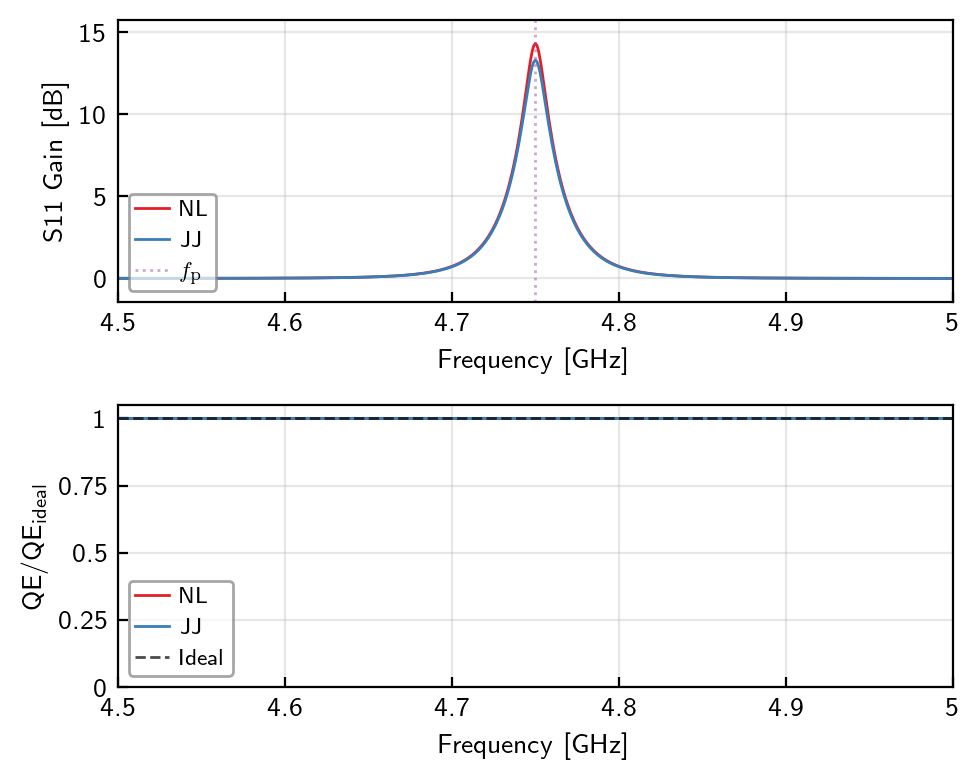

In [11]:
# Cell 7: Results Analysis and Plotting (Comparison of JJ vs NL)

if simulations_success and hasattr(jj, 'results') and hasattr(nl, 'results'):
    
    # Determine amplifier type and correct gain parameter
    is_reflection_amp = (jj.sim_config.signal_port == jj.sim_config.output_port)
    amp_type = "Reflection Amplifier (PA)" if is_reflection_amp else "Transmission Amplifier (TWPA)"
    
    # Determine which S-parameter represents the gain
    if is_reflection_amp:
        if jj.sim_config.signal_port == 1:
            gain_param = "S11"
            jj_gain_data = jj.results.S11
            nl_gain_data = nl.results.S11
        else:  # signal_port == 2
            gain_param = "S22"
            jj_gain_data = jj.results.S22
            nl_gain_data = nl.results.S22
    else:
        # For transmission amp
        if jj.sim_config.signal_port == 1 and jj.sim_config.output_port == 2:
            gain_param = "S21"
            jj_gain_data = jj.results.S21
            nl_gain_data = nl.results.S21
        elif jj.sim_config.signal_port == 2 and jj.sim_config.output_port == 1:
            gain_param = "S12"
            jj_gain_data = jj.results.S12
            nl_gain_data = nl.results.S12
        else:
            gain_param = "S21"
            jj_gain_data = jj.results.S21
            nl_gain_data = nl.results.S21
    
    print("=== Plotting JJ vs NL Comparison ===")
    print(f"Amplifier type: {amp_type}")
    print(f"Gain parameter: {gain_param}")
    
    # Create 2x1 plot layout with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
    
    # Plot 1: Gain comparison (top) - NL first, then JJ on top
    ax1.plot(nl.results.frequencies_GHz, 10*np.log10(nl_gain_data), 
             color=red, linewidth=linewidth, label='NL')
    ax1.plot(jj.results.frequencies_GHz, 10*np.log10(jj_gain_data), 
             color=blue, linewidth=linewidth, label='JJ')
    
    # Add vertical line at pump frequency
    ax1.axvline(jj.sim_config.pump_freq_GHz, color=purple, linestyle=':', 
                alpha=0.5, label=rf'$f_\mathrm{{p}}$')
    
    ax1.set_xlabel('Frequency [GHz]')
    ax1.set_ylabel(f'{gain_param} Gain [dB]')
    ax1.grid(True, alpha=0.3)
    
    # Set y-limits based on gain range
    max_gain = max(10*np.log10(np.max(jj_gain_data)), 10*np.log10(np.max(nl_gain_data)))
    min_gain = min(10*np.log10(np.min(jj_gain_data)), 10*np.log10(np.min(nl_gain_data)))
    gain_range = max_gain - min_gain
    ax1.set_ylim(min_gain - 0.1*gain_range, max_gain + 0.1*gain_range)
    
    legend1 = ax1.legend(
        loc='lower left',  # Changed to bottom left
        fontsize=8,
        frameon=True,
        fancybox=True,
        framealpha=0.7,
        facecolor='white',
        edgecolor='gray',
        borderpad=0.3,
        handlelength=1.5,
        handletextpad=0.5
    )

    ax1.tick_params(axis='x', labelbottom=True)
    ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    
    # Plot 2: Quantum efficiency comparison (bottom) - NL first, then JJ on top
    ax2.plot(nl.results.frequencies_GHz, nl.results.quantum_efficiency, 
             color=red, linewidth=linewidth, label='NL')
    ax2.plot(jj.results.frequencies_GHz, jj.results.quantum_efficiency, 
             color=blue, linewidth=linewidth, label='JJ')
    ax2.axhline(1.0, color=black, linestyle='--', alpha=0.7, label='Ideal')
    
    ax2.set_xlabel('Frequency [GHz]')
    ax2.set_ylabel(r'$\mathsf{QE}/\mathsf{QE}_\mathsf{ideal}$')
    
    # Make legend consistent with first plot
    legend2 = ax2.legend(
        loc='lower left',  # Changed to bottom left
        fontsize=8,
        frameon=True,
        fancybox=True,
        framealpha=0.7,
        facecolor='white',
        edgecolor='gray',
        borderpad=0.3,
        handlelength=1.5,
        handletextpad=0.5
    )
    
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.05)
    ax2.set_xlim(jj.sim_config.freq_start_GHz, jj.sim_config.freq_stop_GHz)
    
    ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    
    plt.tight_layout()
    
    # Performance comparison table
    print("\n" + "="*60)
    print("PERFORMANCE COMPARISON: JJ vs NL")
    print("="*60)
    
    # Calculate metrics for both versions
    for version, gain_data, results in [("JJ", jj_gain_data, jj.results), 
                                        ("NL", nl_gain_data, nl.results)]:
        gain_dB = 10*np.log10(gain_data)
        max_gain_dB = np.max(gain_dB)
        max_gain_idx = np.argmax(gain_dB)
        peak_freq = results.frequencies_GHz[max_gain_idx]
        max_qe = np.max(results.quantum_efficiency)
        min_cm_error = np.min(np.abs(results.commutation_error))
        
        # Find 3dB bandwidth
        gain_3db = max_gain_dB - 3
        above_3db = gain_dB > gain_3db
        bandwidth_GHz = 0
        if np.any(above_3db):
            freq_3db = results.frequencies_GHz[above_3db]
            bandwidth_GHz = freq_3db[-1] - freq_3db[0]
        
        print(f"\n{version} Version:")
        print(f"  Max {gain_param} Gain:    {max_gain_dB:.1f} dB @ {peak_freq:.3f} GHz")
        print(f"  3dB Bandwidth:      {bandwidth_GHz:.3f} GHz")
        print(f"  Max QE:             {max_qe:.3f}")
        print(f"  Min CM Error:       {min_cm_error:.2e}")
    
    # Configuration details
    print("\nConfiguration Details:")
    print(f"  Pump Frequency:     {jj.sim_config.pump_freq_GHz} GHz")
    print(f"  Signal Port:        {jj.sim_config.signal_port}")
    print(f"  Output Port:        {jj.sim_config.output_port}")
    
    # Check if configurations differ
    if jj.sim_config.pump_current_A != nl.sim_config.pump_current_A:
        print(f"  JJ Pump Current:    {jj.sim_config.pump_current_A*1e6:.1f} μA")
        print(f"  NL Pump Current:    {nl.sim_config.pump_current_A*1e6:.1f} μA")
    else:
        print(f"  Pump Current:       {jj.sim_config.pump_current_A*1e6:.1f} μA")
    
    if jj.sim_config.enable_dc_bias:
        if jj.sim_config.dc_current_A != nl.sim_config.dc_current_A:
            print(f"  JJ DC Current:      {jj.sim_config.dc_current_A*1e6:.1f} μA")
            print(f"  NL DC Current:      {nl.sim_config.dc_current_A*1e6:.1f} μA")
        else:
            print(f"  DC Current:         {jj.sim_config.dc_current_A*1e6:.1f} μA")
    
    print("="*60)
    
else:
    print("✗ No simulation results to plot")

In [52]:
# Let me check the flux_jtwpa_example definition in the notebook
print("Checking flux_jtwpa_example components...")

# Check if it's defined
if 'flux_jtwpa_example' in globals():
    jj, nl, circuit_parameters = flux_jtwpa_example
    print(f"Found flux_jtwpa_example with {len(circuit_parameters)} parameters")
    print("\nCircuit parameters:")
    for key, value in circuit_parameters.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.3e}")
        else:
            print(f"  {key}: {value}")
else:
    print("flux_jtwpa_example not found in globals")

Checking flux_jtwpa_example components...
Found flux_jtwpa_example with 11 parameters

Circuit parameters:
  kappa: 9.990e-01
  Lg: 2.000e-08
  Rport: 5.000e+01
  C: 6.920e-14
  C_half: 3.460e-14
  Lj: 1.730e-10
  Lpump: 1.903e-10
  Cpump: 7.612e-14
  Cpump_half: 3.806e-14
  Lsmall: 6.920e-14
  Cj: 3.171e-14
